<a href="https://colab.research.google.com/github/Anjali-K-S25/AI_da/blob/main/Ai_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Remove problematic widget metadata if it exists
if 'widgets' in get_ipython().kernel._parent_header.get('metadata', {}):
    del get_ipython().kernel._parent_header['metadata']['widgets']
    print("Fixed: Removed widget metadata from parent header.")
else:
    print("No widget metadata issue found in current session.")

No widget metadata issue found in current session.


<ipython-input-15-3142456831>:2: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if 'widgets' in get_ipython().kernel._parent_header.get('metadata', {}):


In [ ]:
!pip install -q transformers torch scikit-learn pandas

In [ ]:
!pip install transformers

In [ ]:
import random
import pandas as pd

# Dream templates for each emotion
dream_templates = {
    "peace": [
        "I was floating on a calm lake under the stars",
        "I saw a serene waterfall in a forest",
        "I was lying in a meadow with soft sunlight",
        "I was meditating on a mountaintop in silence"
    ],
    "anxiety": [
        "I was lost in a huge unfamiliar city",
        "I was late for an important exam and couldn’t find the hall",
        "I was running from something invisible in a maze",
        "I was stuck in traffic while missing a flight"
    ],
    "fear": [
        "I was falling endlessly into a black void",
        "I was being chased by shadows in a haunted house",
        "I was locked in a room and couldn’t escape",
        "I saw a loved one disappearing into smoke"
    ],
    "happiness": [
        "I was celebrating my birthday with all my friends",
        "I was dancing at a colorful festival with lights",
        "I met my childhood friend after many years",
        "I was petting playful puppies in a park"
    ]
}

# Generate 100 dream entries
dreams = []
emotions = []

for _ in range(25):
    for emotion, templates in dream_templates.items():
        dream = random.choice(templates) + random.choice([
            ".", " It felt so real.", " Then I woke up smiling.",
            " It made me feel calm.", " I couldn't forget it all day."
        ])
        dreams.append(dream)
        emotions.append(emotion)

dream_data = pd.DataFrame({'dream': dreams, 'emotion': emotions})

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dream_data['label'] = le.fit_transform(dream_data['emotion'])

X_train, X_test, y_train, y_test = train_test_split(
    dream_data['dream'], dream_data['label'], test_size=0.5, random_state=42)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class DreamDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, return_tensors="pt")
        self.labels = torch.tensor(labels.tolist())

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = DreamDataset(X_train, y_train)
test_dataset = DreamDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel
from torch.optim import AdamW

# Define model class
class DreamClassifier(nn.Module):
    def __init__(self, num_labels):
        super(DreamClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.relu(outputs.last_hidden_state[:, 0, :])  # [CLS] token
        x = self.dropout(x)
        return self.classifier(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = DreamClassifier(num_labels=len(le.classes_)).to(device)

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Move model to train mode
model.train()
EPOCHS = 13

for epoch in range(EPOCHS):
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # ====== Validation ======
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            total_val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} → Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    model.train()  # set back to training mode

Epoch 1/13 → Train Loss: 1.3657, Train Acc: 0.3200, Val Loss: 1.1578, Val Acc: 0.6400
Epoch 2/13 → Train Loss: 0.8184, Train Acc: 0.8800, Val Loss: 0.4933, Val Acc: 0.9800
Epoch 3/13 → Train Loss: 0.2714, Train Acc: 1.0000, Val Loss: 0.1900, Val Acc: 0.9800
Epoch 4/13 → Train Loss: 0.0960, Train Acc: 1.0000, Val Loss: 0.1168, Val Acc: 1.0000
Epoch 5/13 → Train Loss: 0.0530, Train Acc: 1.0000, Val Loss: 0.0795, Val Acc: 1.0000
Epoch 6/13 → Train Loss: 0.0373, Train Acc: 1.0000, Val Loss: 0.0665, Val Acc: 1.0000
Epoch 7/13 → Train Loss: 0.0295, Train Acc: 1.0000, Val Loss: 0.0597, Val Acc: 1.0000
Epoch 8/13 → Train Loss: 0.0222, Train Acc: 1.0000, Val Loss: 0.0570, Val Acc: 1.0000
Epoch 9/13 → Train Loss: 0.0201, Train Acc: 1.0000, Val Loss: 0.0536, Val Acc: 1.0000
Epoch 10/13 → Train Loss: 0.0172, Train Acc: 1.0000, Val Loss: 0.0516, Val Acc: 1.0000
Epoch 11/13 → Train Loss: 0.0159, Train Acc: 1.0000, Val Loss: 0.0506, Val Acc: 1.0000
Epoch 12/13 → Train Loss: 0.0163, Train Acc: 1.0000,

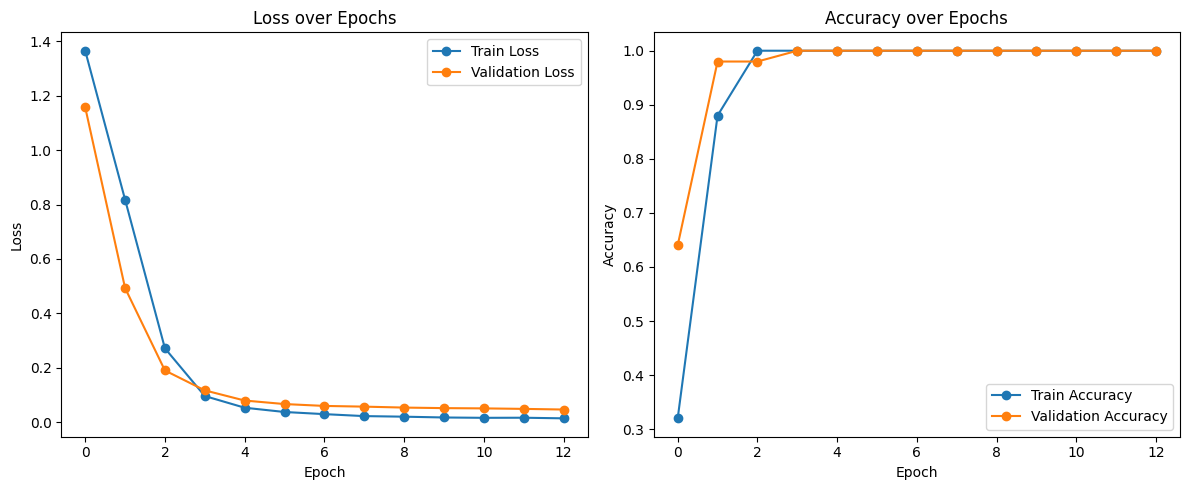

In [ ]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import torch

# --- AI Prediction Logic ---
def predict_dream(dream_text):
    model.eval()
    with torch.no_grad():
        tokens = tokenizer(dream_text, truncation=True, padding=True, return_tensors="pt").to(device)
        outputs = model(input_ids=tokens["input_ids"], attention_mask=tokens["attention_mask"])
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        pred_label = le.inverse_transform([probs.argmax()])[0]

        result = f"## Emotional Condition: `{pred_label}`\n\n"
        result += "### Confidence Levels:\n"
        for i, label in enumerate(le.classes_):
            result += f"- {label}: **{probs[i]*100:.2f}%**\n"
        return result, "output"

# --- FAQ Content ---
faq_content = """
### Frequently Asked Questions (FAQ)

**1. What is this app for?**
This application is designed to analyze the content of dreams using artificial intelligence. By processing your dream description, the model predicts the emotional or psychological condition likely associated with it.

**2. How does it work?**
The model is trained on a labeled dataset of dream texts using a transformer-based neural network. It identifies emotional patterns by analyzing linguistic cues and structures in your written description.

**3. Can I input nightmares or lucid dreams?**
Yes, the model accepts all types of dreams—nightmares, lucid dreams, recurring dreams, or symbolic ones. The more descriptive your input, the better the model can analyze it.

**4. Is this medical advice?**
No, this is an experimental AI-based analysis tool and is not intended for diagnosis or therapy. It should not replace consultation with a mental health professional.

**5. What emotions can it detect?**
The system is trained to recognize a range of emotional states such as calmness, fear, anxiety, sadness, joy, and stress. These are generalized categories based on the language in your dream.

**6. Will my input be saved?**
No, your input is not saved or stored anywhere by this application. It runs in a temporary session and processes your data locally during the session only.

**7. Can I use it on my phone?**
Yes, the interface is mobile-friendly and works in mobile browsers. You can input your dream and view results just as you would on a desktop.

**8. Is the result explainable?**
Currently, the app provides the prediction and confidence levels, but it does not provide detailed explainability. Future versions may include XAI (Explainable AI) tools like SHAP or LIME to explain predictions.

**9. Can I trust the prediction?**
The prediction is based on trained data and language modeling but is not 100% accurate. It's best used for exploration and reflection rather than for making conclusions about your mental health.

**10. How to improve prediction?**
Give detailed and vivid dream descriptions with context, emotions, events, and how you felt during and after the dream. More specific input leads to more meaningful predictions.

**11. Can this be integrated into other platforms?**
Yes, the backend model can be exported or deployed as an API and integrated into mobile apps, websites, or other mental health and wellness platforms for research or experimentation.
"""

# --- Gradio Interface ---
with gr.Blocks(title="Dream Emotion Analyzer") as demo:
    current_screen = gr.State("input")

    with gr.Column(visible=True) as input_screen:
        gr.Markdown("## 🧠 Dream Emotion Analyzer")
        gr.Markdown("Enter your dream description below. Our AI will analyze it and detect possible emotional conditions.")

        dream_input = gr.Textbox(label="Enter Your Dream", lines=5, placeholder="Describe your dream here...")
        analyze_btn = gr.Button("Analyse Dream")
        faq_btn = gr.Button("View FAQ")

    with gr.Column(visible=False) as output_screen:
        gr.Markdown("## 🔍 Analysis Result")
        result_output = gr.Markdown()
        back_btn = gr.Button("Back to Input")

    with gr.Column(visible=False) as faq_screen:
        gr.Markdown("## 📘 Frequently Asked Questions")
        gr.Markdown(faq_content)
        back_btn_faq = gr.Button("Back to Input")

    def handle_analyze(text):
        result, nav = predict_dream(text)
        return result, gr.update(visible=False), gr.update(visible=True), gr.update(visible=False)

    def go_back():
        return gr.update(visible=True), gr.update(visible=False), gr.update(visible=False)

    def go_faq():
        return gr.update(visible=False), gr.update(visible=False), gr.update(visible=True)

    analyze_btn.click(fn=handle_analyze, inputs=dream_input,
                      outputs=[result_output, input_screen, output_screen, faq_screen])

    back_btn.click(fn=go_back, outputs=[input_screen, output_screen, faq_screen])
    faq_btn.click(fn=go_faq, outputs=[input_screen, output_screen, faq_screen])
    back_btn_faq.click(fn=go_back, outputs=[input_screen, output_screen, faq_screen])

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3dc02b3c8602ca830a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
